In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 361 (delta 108), reused 93 (delta 67), pack-reused 171
Receiving objects: 100% (361/361), 55.83 MiB | 23.94 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=26856 sha256=7842b119343ed1afb9a42496b336ab9a7eb1a1224c12edeae72d4e11079b1747
  Stored in directory: /tmp/pip-ephem-wheel-cache-7a32gddb/wheels/55/59/29/0fb1c6356521

In [2]:
from dul_2021.utils.hw11_utils import *

In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.normal import Normal
from torchvision import transforms

from typing import Tuple, Union, List

import copy

from tqdm.notebook import tqdm, trange

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [7]:
class Predictor(nn.Module): 
    def __init__(self, input_dim: int): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim), 
            nn.BatchNorm1d(input_dim), 
            nn.LeakyReLU(), 
            nn.Linear(input_dim, input_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.model(x)


class Encoder(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            nn.Conv2d(1, 32, 3, 1, 1), # 1 x 28 x 28 -> 32 x 28 x 28
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # -> 64 x 14 x 14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), # -> 128 x 7 x 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), # -> 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(), 
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128))

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.model(x)

In [8]:
class BYOL(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.student = Encoder()
        self.teacher = Encoder()
        self.initialize_teacher()
        self.predictor = Predictor(128)
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=28),
            transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
        ])
        self.m = 0.99

    def initialize_teacher(self):
        for param_q, param_k in zip(self.student.parameters(), self.teacher.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

    def update_teacher(self):
        for param_q, param_k in zip(self.student.parameters(), self.teacher.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    def loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor: 
        x = F.normalize(self.predictor(self.student(x)), dim=1)
        with torch.no_grad(): 
            y = F.normalize(self.teacher(y), dim=1)
        loss = 2 - 2 * (x * y).sum(dim=-1)
        return loss

    def sym_loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor: 
        sym_loss = self.loss(x, y) + self.loss(y, x) 
        return sym_loss.mean()

    def fit(self, 
            dataset: np.ndarray, 
            lr: float = 3e-4, 
            batch_size: int = 128, 
            epochs: int = 20) -> np.ndarray:
        self.train()
        optim = opt.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []
        for _ in trange(epochs, desc="Epoch"): 
            for batch in tqdm(data_loader, desc="Iter", leave=False): 
                x = self.transforms(batch).to(device)
                y = self.transforms(batch).to(device)

                loss = self.sym_loss(x, y)
                optim.zero_grad()
                loss.backward()
                optim.step()

                self.update_teacher()
                losses.append(loss.item())
        
        return np.array(losses)

    def encode(self, batch: torch.Tensor) -> torch.Tensor: 
        self.eval()
        with torch.no_grad():
            batch = batch.to(device)
            out = self.student(batch).detach().cpu()
        return out

In [12]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    model = BYOL().to(device)
    losses = model.fit([im for im, _ in train_data], epochs=20)
    return losses, model.encode

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

Iter:   0%|          | 0/469 [00:00<?, ?it/s]

mean classification accuracy=0.9488


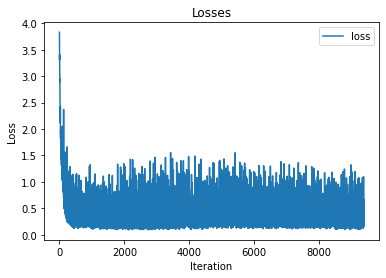

In [13]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [85]:
class Encoder(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            nn.Conv2d(3, 32, 3, 1, 1), # 3 x 32 x 32 -> 32 x 32 x 32
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # -> 64 x 16 x 16
            nn.LeakyReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), # -> 128 x 8 x 8
            nn.LeakyReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), # -> 128 x 4 x 4
            nn.LeakyReLU(), 
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.model(x)


class Projector(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(128, 128), 
            nn.BatchNorm1d(128), 
            nn.LeakyReLU(), 
            nn.Linear(128, 128), 
            nn.BatchNorm1d(128), 
            nn.LeakyReLU(), 
            nn.Linear(128, 128)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.model(x)

In [86]:
class BarlowTwins(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.encoder = Encoder() 
        self.projector = Projector()
        self.bn = nn.BatchNorm1d(128, affine=False)
        self.lambd = 1e-2
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=32),
            transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
        ])

    def loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor: 
        z_x = self.projector(self.encoder(x))
        z_y = self.projector(self.encoder(y))

        bs = x.shape[0]
        c = self.bn(z_x).T @ self.bn(z_y) / bs
        n, m = c.shape 

        on_diag = ((torch.diagonal(c) - 1) ** 2).sum()
        off_diag = c.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()
        off_diag = (off_diag ** 2).sum()
        loss = on_diag + self.lambd * off_diag
        return loss

    def fit(self, 
            dataset: np.ndarray, 
            lr: float = 3e-4, 
            batch_size: int = 128, 
            epochs: int = 20) -> np.ndarray:
        self.train()
        optim = opt.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []
        for _ in trange(epochs, desc="Epoch"): 
            for batch in tqdm(data_loader, desc="Iter", leave=False): 
                x = self.transforms(batch).to(device)
                y = self.transforms(batch).to(device)

                loss = self.loss(x, y)
                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
        
        return np.array(losses)

    def encode(self, batch: torch.Tensor) -> torch.Tensor: 
        self.eval()
        with torch.no_grad():
            batch = batch.to(device)
            out = self.encoder(batch).detach().cpu()
        return out

In [87]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1
    test_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1 (not used!)

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    model = BarlowTwins().to(device)
    losses = model.fit([im for im, _ in train_data], epochs=20)
    return losses, model.encode

Files already downloaded and verified
Files already downloaded and verified


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

Iter:   0%|          | 0/391 [00:00<?, ?it/s]

mean classification accuracy=0.4662


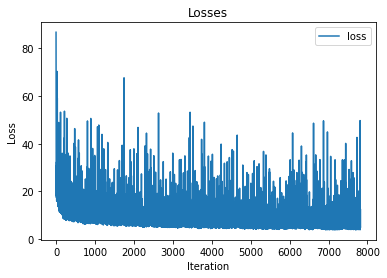

In [88]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)